# Katelyn Stuart - Technical Assessment

## Overview 
The goal of this analysis is to determine reasonable and defensible methods for classifying the production year of the dataset. The dataset is composed of the production year of each song and 90 attributes, the average timbre of 12 song segments, and 78 timbre covariances (all per song). Timbre is a measure of tone, pitch, loudness, etc, that represents context of sound. For example, the timbre of a violin will be different than that of a trumpet or a piano playing the same note at the same pitch and volume, allowing us to distinguish different instruments from each other. 

This data was curated from UC Irvine and represents a subset of the Million Song Dataset, a freely available collection of audio features, including timbre. Preliminary research into the original dataset shows that the dataset primarily contains western songs. There are cover songs present in the dataset as well, which likely have similar timbre to the originals. 

There are 515,345 observations within the data set and the UC Irvine overview requires that the first 463,715 examples be used to train and the the last 51,630 examples for testing in order to avoid the "producer effect" by making sure no song from a given artist ends up in both the train and test set.

We begin by importing the libraries that we will use to conduct exploratory analysis and to build models. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.svm import SVC

## Exploratory Data Analysis

We begin by importing the dataset, creating a new variable for "decade" which we will use below to help visualize data in our exploratory analysis and separate the data into the recommended train and test splits. 

In [2]:
#load the data from txt file downloaded from http://archive.ics.uci.edu/dataset/203/yearpredictionmsd
df = pd.read_csv('YearPredictionMSD.txt', sep=',', header=None)

#label the columns with year (target variable) and features
df.columns = ['year'] + [f'feature_{i}' for i in range(90)]

#adding decade to the dataset for visualization and prediction downstream
df['decade'] = df.year.apply(lambda year : year-(year%10)).astype('category')

#separate the dataset into train and set based on the requirements in the UCI Details
train = pd.DataFrame(df.iloc[:463715,:])
test = pd.DataFrame(df.iloc[463715:])

In [3]:
train.shape

(463715, 92)

Assessing the shape of the dataset, the number of features, and their distriubtions. As highlighted in the data description, there is one target, "production year", which we will label 'year', and 90 features. 

In [4]:
train.describe()

,year,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89
count,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,...,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000,463715.000000
mean,1998.386095,43.385488,1.261091,8.650195,1.130763,-6.512725,-9.565527,-2.384609,-1.793722,3.714584,...,15.743361,-73.067753,41.423976,37.780868,0.345259,17.599280,-26.364826,4.444985,19.739307,1.323326
std,10.939767,6.079139,51.613473,35.264750,16.334672,22.855820,12.836758,14.580245,7.961876,10.579241,...,32.086356,175.376872,121.794610,94.874474,16.153797,114.336522,174.187892,13.320996,184.843503,22.045404
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-318.223330
25%,1994.000000,39.957540,-26.153810,-11.441920,-8.515155,-20.636960,-18.468705,-10.776340,-6.461400,-2.303600,...,-1.798085,-139.062035,-20.918635,-4.711470,-6.758160,-31.563615,-101.396245,-2.572830,-59.598030,-8.813335
50%,2002.000000,44.262570,8.371550,10.470520,-0.691610,-5.992740,-11.208850,-2.047850,-1.735440,3.816840,...,9.161360,-52.878010,28.709870,33.494550,0.828350,15.554490,-21.123570,3.111120,7.586950,0.052840
75%,2006.000000,47.833650,36.143780,29.741165,8.756995,7.749590,-2.422590,6.515710,2.905130,9.950960,...,26.248290,13.620660,89.419995,77.674700,8.495715,67.743725,52.299850,9.948955,86.203115,9.670740
max,2011.000000,61.970140,384.065730,322.851430,289.527430,262.068870,119.815590,172.402680,105.210280,146.297950,...,840.973380,4469.454870,3210.701700,1672.647100,260.544900,3662.065650,2833.608950,463.419500,7393.398440,600.766240


The features are all numerical but the have varying skewness and range. 

In [5]:
train.year.value_counts()

2007    35375
2006    33824
2005    31454
2008    31244
2009    27907
        ...  
1925        7
1922        6
1933        6
1924        5
2011        1
Name: year, Length: 89, dtype: int64

There are 89 years present within the training set. 

In [6]:
test.year.value_counts()

2007    4029
2006    3710
2008    3516
2005    3498
2009    3131
        ... 
1930       2
1944       1
1943       1
1941       1
1934       1
Name: year, Length: 78, dtype: int64

There are 78 years present within the testing set. 

In order to build a model for years, both the test and train dataset were cleaned up to ensure all years in the testing set were present in training, and vice versa. 

In [7]:
# Create a list of unique years present in the 'test' DataFrame
test_years = test['year'].unique()
train_years = train['year'].unique()

# Filter the 'train' DataFrame to include only the rows with years that are present in 'test'
train_filtered = train[train['year'].isin(test_years)]
test_filtered = test[test['year'].isin(train_years)]

In [8]:
test_filtered.year.value_counts()

2007    4029
2006    3710
2008    3516
2005    3498
2009    3131
        ... 
1930       2
1944       1
1943       1
1941       1
1934       1
Name: year, Length: 78, dtype: int64

In [9]:
train_filtered.year.value_counts()

2007    35375
2006    33824
2005    31454
2008    31244
2009    27907
        ...  
1936       22
1942       21
1944       14
1940       14
1943       13
Name: year, Length: 78, dtype: int64

We can see from the plot below that there is quite the imbalance in observations per year, peaking in the 2000s. This was highlighted in the data description, but it's always good to visualize. We can see that the training data is representative to the imbalance seen within the test set. 

<AxesSubplot:ylabel='Density'>

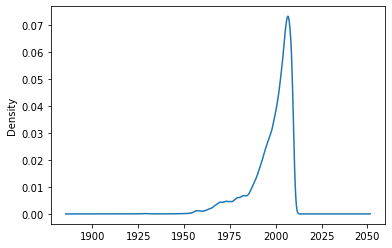

In [10]:
train_filtered.year.plot.density()

<AxesSubplot:ylabel='Density'>

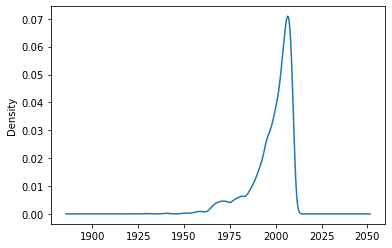

In [11]:
test_filtered.year.plot.density()

As there are 90 features, visualizing them all one by one is possible but not a terrifically feasible way to quickly digest the information. A quick glance at the first 25 features below, illustrates that there is more variation in the features as we increase in decades, indicating that we may be able to better predict songs in later decades due to wider ranges in these features not seen in earlier years. There is significant overlap in feature value ranges in earlier decades. Visualizing the first 25 features allows us to see the data for both the "average timbre" (features 0-11) and "timbre covariance" features (12-89). 

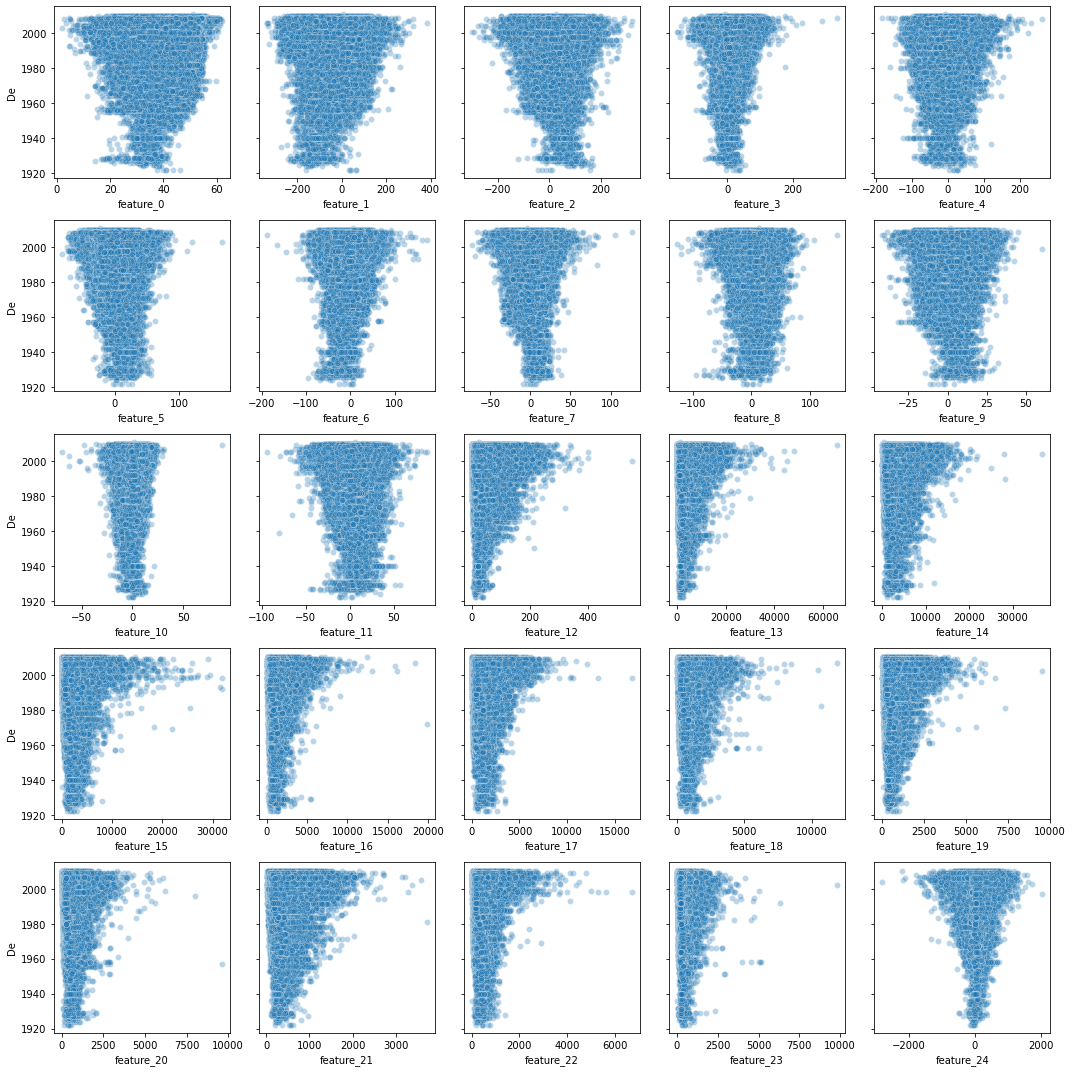

In [12]:
# Get the first 25 feature columns for plotting
num_features_to_plot = 25
features_to_plot = [f'feature_{i}' for i in range(num_features_to_plot)]

# Create subplots with 5 plots in each row
num_rows = 5
num_cols = num_features_to_plot // num_rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15), sharey=True)

# Flatten the axes array for easy plotting
axes = axes.flatten()

# Scatter plots of the first 25 features against the target variable 'year'
for i, feature in enumerate(features_to_plot):
    sns.scatterplot(data=df, x=feature, y='year', alpha=0.3, ax=axes[i])
    axes[i].set_xlabel(feature)
    if i % num_cols == 0:
        axes[i].set_ylabel('De')

plt.tight_layout()
plt.show()

From looking at the scatter plots above, it doesn't appear that there are linear relationships between the target variable and the features, but we can test for this. Below, we use the pearson correlation to check for linear and spearman for monotonic. 

The background is colored according to gradient to help quickly visualize a sense of magnitude of correlation and the direction. The darker blue means higher positive corrleation and the darker red indicates higher negative correlation. 

In [13]:
(train_filtered
.corr(method='pearson')
.style
.background_gradient(cmap='RdBu', vmin=-1, vmax=1)
)

While most pearson correlations are weak, it appears that some features may have linear relationships and we may be able to simply the features and run PCA on this subset of features in the future, should we not see results applying on the full dataset. Below we create a group of the features that appear to have higher linear correlation should we need it in later analysis. 

In [14]:
linear_features = ['year', 'decade', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
                      'feature_12', 'feature_13', 'feature_14','feature_15', 'feature_16', 
                      'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 
                      'feature_22', 'feature_23',
                      'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31',
                      'feature_32', 'feature_33', 'feature_34',
                      'feature_48', 'feature_78', 'feature_80']

Spearman correlation is useful to measure the strength of a monotonic relationship between two variables or when the data is not linear. Due to the gradient, it is easier to quickly assess that there is a stronger monotonic correlation between many variables than linear, again further indicating that we may wish to consider non-linear models. 

In [15]:
(train_filtered
.corr(method='spearman')
.style
.background_gradient(cmap='RdBu', vmin=-1, vmax=1)
)

As this is a high dimensionality dataset, visualizing the relationship between all the variables and the target variable is not possible. Principal Component Analysis (PCA) can be useful in both visualizing the data in a lower dimensional space. However, PCA is best used when relationships are linear and may not capture infortmation when not. 

In order to run PCA we need to scale the features. The `StandardScaler()` function transforms the dataset so that each feature has a mean of 0 and a standard deviation of 1. 

For simplicity of visualization, we will create two principal components so that we can plot on an X:Y axis. 

In [16]:
train_features = train_filtered.iloc[:,1:91]
train_decade = train_filtered['decade']
train_year = train_filtered['year']

scaled_train_features = StandardScaler().fit_transform(train_features)

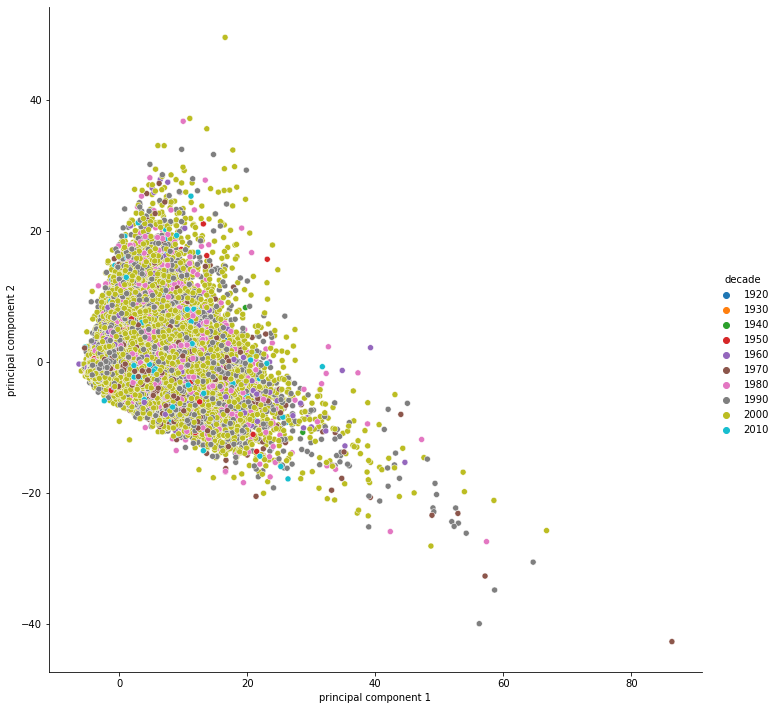

In [17]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(scaled_train_features)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, train_filtered[['decade']]], axis = 1)
sns.pairplot(finalDf, 
             hue="decade",
             x_vars="principal component 1",
             y_vars="principal component 2",
             height=10)

We chose to visualize decade instead of year for ease of viewing. It is clear that PCA has not done a good job of isolating the informaiton to separate the classes. Perhaps this is because we included a lot of features that we knew were not linear. 

Let's try again with the subset of features that had higher correlation. 

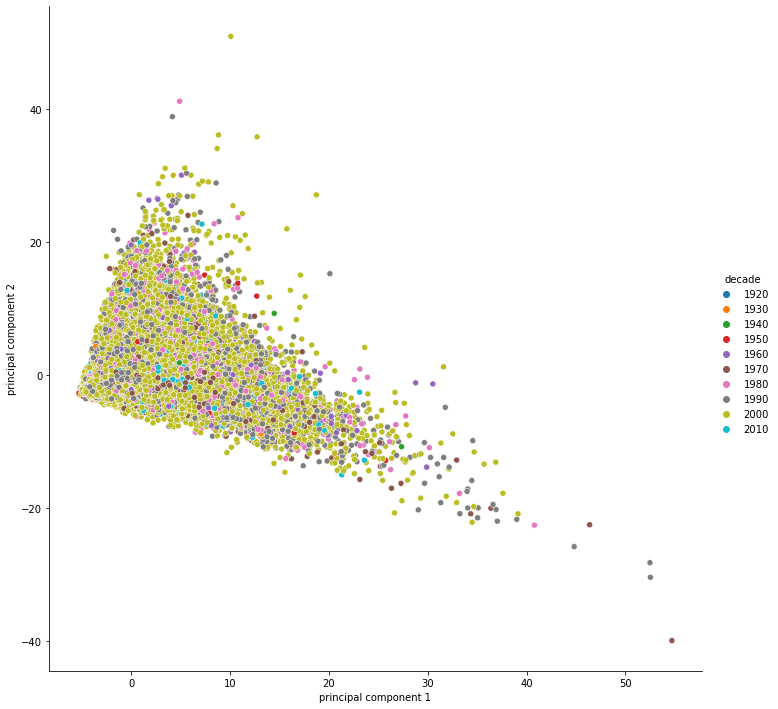

In [18]:
#subset to features that look linear per pearson corr

train_features_linear = train_filtered[linear_features]

scaled_train_features_linear = StandardScaler().fit_transform(train_features_linear)

principalComponents_lin = pca.fit_transform(scaled_train_features_linear)
principaldf_lin = pd.DataFrame(data = principalComponents_lin, 
                           columns = ['principal component 1', 'principal component 2'])
finalDf_lin = pd.concat([principaldf_lin, train_filtered[['decade']]], axis = 1)
sns.pairplot(finalDf_lin, 
             hue="decade",
             x_vars="principal component 1",
             y_vars="principal component 2",
             height=10)

It doesn't look much better. PCA does not appear to be successful in segmenting by decade, further indicating that there is not a linear relationship between the target and features. 

We can try a non-linear technique later if dimension reduction becomes important for computatation time. For now, are other approaches to reduce computational time that we will explore below. 

## Methodology

As discussed, the goal of this analysis is to determine a few unique and defensible approaches to landing on a prediction of "year" given the features provided. 

### Data Prep

We learned in the exploratory analysis that this is a high dimensional data set with 90 features and 78 unique classes (years). All variables are numeric so the only preprocessing we need to do is to standardize the dataset. While not all models require standardization, its a good practice to standardize so that models that are sensitive to variation in variables can be compared. 

Additionally, the training data is too large to train in a reasonable amount of time. Therefore, to reduce computational time we will need a smaller training dataset. There are many sampling options. 

We know that this is a highly imbalanced dataset. Some models handle class imbalance better than others. In the interest of being able to leverage one data set to compare multiple models we will not apply data resampling or balancing techniques such as oversampling, undersampling, or sythentic data generation. With a more thorough analysis, balancing techniques would be considered. 

To simplify and to reduce computational time, we will use a random sampling of 10% of the training data and then we will create our Train and Test datasets. `X` represents the features that will be used to train the model. `y` represents the target variable, in this case, `year` but we have created a second target variable for `decade` in case we do not have enough information to predict the exact year, we may be able to reasonably predict the decade instead. 

<AxesSubplot:ylabel='Density'>

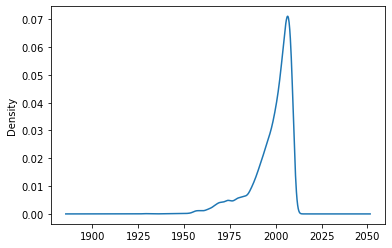

In [19]:
train_10 = train_filtered.sample(frac=0.1, random_state=42) #randomly sample 10% of training data, set random state for repeatability

train_10.year.plot.density()

In [20]:
train_features = train_10.iloc[:,1:91]
X_train = StandardScaler().fit_transform(train_features)
y_train_decade = train_10['decade']
y_train_year = train_10['year']

test_features = test_filtered.iloc[:,1:91]
X_test = StandardScaler().fit_transform(test_features)
y_test_decade = test_filtered['decade']
y_test_year = test_filtered['year']

### Feature Selection

We saw that PCA was ineffective in identifying variation between decades, so it is unlikely it would be useful for years. This is likely because the relationships are not linear. 

Another approach for dimension reduction is to use Random Forest to get a sense of which features are most important. Random Forest handles non-linear relationships and high dimensionality effectively. However, it is sentistive to class imbalance and prone to overfit in instances of class imbalance. We can mitigate overfitting, and computational load, with a reduced number of trees. 

In [21]:
# Create the Random Forest Classifier with a reduced number of trees (e.g., 50 trees)
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train_year)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': train_features.columns, 'Importance': feature_importances})

# Sort the DataFrame by Importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#create an array with the top ten features to potentially use for dimension reduction later
top10features = feature_importance_df.iloc[:10, :]['Feature'].array

However, when we check the accuracy of the model, it is only 7%. A quick glance at the confusion matrix and we can see that the model does not classify any examples into the years before 1965. As expected, precision and recall are highest for 2005-2008 where the model has the most examples. This is a common problem for random forest models and unbalanced data sets. 

This seems like very low accuracy, but it is an improvement over randomly guessing.  We also know that there are cover songs in the dataset that may be confusing the model. Additionally, running a model to classify to exact year means that if the model predicts 1995 but the song is from 1996, this is considered to be just as wrong as if the model was to classify the song into 1935. It's likely that asking the model to predict the decade, giving it a bit more leeway, would perform better and perhaps give us some insights into what features are more infortmative. 

In [22]:
# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test)

# Analyze the model's performance using various evaluation metrics
print("Accuracy:", accuracy_score(y_test_year, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_year, y_pred, zero_division=0)) # setting zero division to 0 because there are samples with no predictions

Accuracy: 0.07013364323067983

Classification Report:
              precision    recall  f1-score   support

        1927       0.00      0.00      0.00         2
        1928       0.00      0.00      0.00         4
        1929       0.00      0.00      0.00        14
        1930       0.00      0.00      0.00         2
        1931       0.00      0.00      0.00         4
        1934       0.00      0.00      0.00         1
        1936       0.00      0.00      0.00         3
        1937       0.00      0.00      0.00         3
        1940       0.00      0.00      0.00        38
        1941       0.00      0.00      0.00         1
        1942       0.00      0.00      0.00         3
        1943       0.00      0.00      0.00         1
        1944       0.00      0.00      0.00         1
        1945       0.00      0.00      0.00         3
        1947       0.00      0.00      0.00         2
        1948       0.00      0.00      0.00         5
        1949       0.00    

Below we run random forest to predict the decade of the song instead of the year. While the accuracy is better, 60%, we still see that the model was unable to make any classifications for decades before 1970. 

In [23]:
# Create the Random Forest Classifier with a reduced number of trees (e.g., 50 trees)
rf_model_decade = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model_decade.fit(X_train, y_train_decade)

# Use the trained model to make predictions on the test data
y_pred_decade = rf_model_decade.predict(X_test)

# Analyze the model's performance using various evaluation metrics
print("Accuracy:", accuracy_score(y_test_decade, y_pred_decade))
print("\nClassification Report:")
print(classification_report(y_test_decade, y_pred_decade, zero_division=0))

Accuracy: 0.6009103234553554

Classification Report:
              precision    recall  f1-score   support

        1920       0.00      0.00      0.00        20
        1930       0.00      0.00      0.00        13
        1940       0.00      0.00      0.00        61
        1950       0.00      0.00      0.00       275
        1960       0.00      0.00      0.00      1166
        1970       0.41      0.01      0.01      2396
        1980       0.52      0.03      0.07      4201
        1990       0.40      0.21      0.27     12580
        2000       0.63      0.94      0.76     29885
        2010       0.00      0.00      0.00      1033

    accuracy                           0.60     51630
   macro avg       0.20      0.12      0.11     51630
weighted avg       0.52      0.60      0.51     51630



Unfortunately, it seems futile to leverage the features deemed important by the random forest to reduce the dimensionality of the data set as it was unable to classify songs in any decades before 1970, nevermind the right years. 

Given more time, we should work towards enhancing the data set with additional features that distinguish earlier decades from later decades. Additionally, as previously mentioned, applying balancing techniques may also improve the performance. 

### MODEL SELECTION

The Random Forest was useful to start out with because it is more easily explained than other, more powerful models. It may have also helped us to reduce our features by identifying the most important for distinguishing between years/decades. 

However, with this dataset, it seems that we will need to trade interpretability for accuracy. There are many algorithm options to choose from and the goal of this analysis is not to find the best but instead to discuss a few options:

Reviewing the dataset and its limitations:
- Standardized Numeric 
- Non-linear
- High dimensionality
- Multiple classes
- Highly imbalanced, especially for years in earlier decades

Some options to explore: 
- XGBoost
- Support Vector Machine (SVM)

Let's discuss each method, then apply each to our year predictions. 

XGBoost: 

Even though we did not get great results with Random Forest, it worth trying XGBoost. Similar to Random Forest, XGBoost is a tree based algoriths. However, where Random Forest builds independent decision trees with random subsets of data and features, while XGBoost builds trees sequentially to correct errors made by previous trees. Random Forest uses majority voting to make predictions, whereas XGBoost uses a gradient boosting approach that optimizes a loss function by adding trees sequentially, minimizing errors and improving model accuracy. It prevents overfitting and handles high-dimensional data effectively. 

As with any "black box" model, it is difficult to interpret and explain. It does provide importance for each feature. To really get XGBoost to shine, hyperparameter tuning is essential for optimal performance, which can be time-consuming and will not be considered in this analysis. It can also be quite computationally expensive, so we will minimize this by limiting trees and depth. 

SVM (Support Vector Machine):

SVM aims to find the optimal hyperplane that best separates data points from different classes in a high-dimensional feature space. SVM works by transforming data points into a higher-dimensional space using a kernel function to enable the linear separation of classes. The algorithm seeks to maximize the margin between the support vectors (data points closest to the decision boundary) from different classes, making SVM robust against overfitting. 

As with XGBoost, it can be difficult to interpret and explain the results. Computational time can be slow on large or imbalanced data sets and it can be sentitative to performance issues on unbalanced data. 

It's difficult to say which model will perform better on our dataset, especially as both models are quite sensitive to hyperparamter tuning. We will not be doing that in this analysis but will run both models on year to see what results we can get on the first pass. 

Label encoding assigns a unique integer to each category in a categorical feature. This is a necessary preprocessing step for both XGBoost and SVM. 

In [24]:
# Assuming 'y' contains the target variable with year labels

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable 'y' to encode it as consecutive integers
y_encoded = label_encoder.fit_transform(y_train_year)

# Display the unique classes after encoding
print("Unique classes after encoding:", np.unique(y_encoded))

# Assuming 'y' contains the target variable with year labels

y_encoded_test = label_encoder.fit_transform(y_test_year)

# Display the unique classes after encoding
print("Unique classes after encoding:", np.unique(y_encoded_test))

label_mapping_df = pd.DataFrame({
    'Original_Label': label_encoder.classes_,
    'Numerical_Code': label_encoder.transform(label_encoder.classes_)
})

label_mapping_df

Unique classes after encoding: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
Unique classes after encoding: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]


,Original_Label,Numerical_Code
0,1927,0
1,1928,1
2,1929,2
3,1930,3
4,1931,4
...,...,...
73,2006,73
74,2007,74
75,2008,75
76,2009,76


#### XGBoost 
We will run XGBoost on the Macbook GPU to decrease the time it takes to compute. If you are not running this code on a Macbook with a GPU, skip this step. 

In [25]:
# if not running on Macbook with GPU do not run this step

import os
os.environ["XGBOOST_BUILD_WITH_GPU"] = "1"

In [26]:
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=78,               # Number of classes
    n_estimators=50,            # Number of boosting rounds (trees)
    max_depth=3,                # Maximum depth of each tree
    learning_rate=0.1,          # Learning rate (step size for each iteration)
    random_state=42
)

# Train the XGBoost model
xgb_model.fit(X_train, y_encoded)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_class=78,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [27]:
#make predictions with XGB
xgb_predictions = xgb_model.predict(X_test)

In [28]:
accuracy = accuracy_score(y_encoded_test, xgb_predictions)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_encoded_test, xgb_predictions, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_encoded_test, xgb_predictions))

Accuracy: 0.07838466008134805
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         5
          16       0.00     

#### Support Vector Machine

In [29]:
from sklearn.svm import SVC
svm_model = SVC(kernel='rbf',     # for non-linear
                C=1.0,            # Regularization parameter (default=1.0)
                random_state=42
)

# Train the SVM model
svm_model.fit(X_train, y_encoded)

SVC(random_state=42)

In [30]:
# Make predictions with SVM
svm_predictions = svm_model.predict(X_test)

In [31]:
accuracy = accuracy_score(y_encoded_test, svm_predictions)
print("Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_encoded_test, svm_predictions, zero_division=0))

print("Confusion Matrix:")
print(confusion_matrix(y_encoded_test, svm_predictions))

Accuracy: 0.08260701142746465
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         5
          16       0.00     

## Summary

In summary, we were able to slightly increase the accuracy of the predictions by running more complex models, XGBoost and SVM. 

- Random Forest Accuracy: 7.01%
- XGBoost Accuracy: 7.84%
- SVM Accuracy: 8.26%

Although SVM and XGBoost models performed slightly better, they are far more computationally expensive and it seems unlikely that the additional gain of just 1-2% accuracy would be worth the cost. When dealing with standardized numeric, non-linear, high-dimensional, multi-class, and highly imbalanced data, it is important to preprocess the data appropriately for each model. This may include applying techniques to handle class imbalance, and definitely requires more careful tuning of hyperparameters for each model. This analysis did not attempt to tune any parameters beyond the initial run where the model was adjusted to limit computational time, likely at the expense of performance. We also made the choice to first train on 10% of the data instead of applying balancing techniques, in order to get a sense of how predictive the features were as is. 

Given that all three models struggled to classify any years before 1960-1970, with poor precision and recall metrics for most classes, it possible that applying balancing techniques such as SMOTE or undersampling the more popular classes may improve the performance. However, unfortunately, we saw from the exploratory analysis that timbre alone does not seem to distinguish differences between years or even decades. Music from later decades tends to both mirror and expand upon the timbres of music from earlier decades. This makes it difficult for the model to classify. We also learned from researching the original data set that there are many cover songs in the dataset, which likely have similar timbre to the original song. These would also confuse the model and should be idenitified and labeled. 

In order to improve the model performance, getting a better understanding of the original dataset would be beneficial. It is likely that timbre alone is not enough information about a song to accurately map it back to its decade, nevermind specific year. There are other features within the original Million Song Dataset that may be more useful in helping to identify songs that are misclassified and increase the overall accuracy. Additionally, we should work specifically towards enhancing the data set with additional features that distinguish earlier decades from later decades.